# Bike Sharing Rebalancing Problem

The following implementation is derivated from the following paper: https://www.sciencedirect.com/science/article/abs/pii/S0305048313001187


## Introduction

| Variable Name  | Description |
| ------------- | ------------- |
| <i>V</i>   | Set of vertices |
| <i>A</i>   | Set of arcs  |
| <i>n</i>   | Number of stations |
| <i>m</i>   |  Number of vehicles  |
| <i>Q</i>   | Vehicle capacity |
| <i>q<sub>i</sub></i>  |  Demand at vertex i  |
| <i>c<sub>ij</sub></i>  |  Cost of arc (i,j)  |

In [1]:
#Importing cplex API
import sys
import docplex.cp

#Importing numpy and random generator
import numpy as np
rand = np.random

#Importing pyplot
import matplotlib.pyplot as plt

#Importing docplex model
from docplex.mp.model import Model
import itertools

In [124]:
#Initial values
n = 6                                      # amount of stations (Reggio-Emilia)
m = 2                                            # amount of vehicles
Q = 10                                           # vehicles capacity
end = n + 1
Vo = [i for i in range(1, n+1)] # stations without starting and ending deposit   
V = [0] + Vo + [end] 
#A = [(i, j) for i in V for j in V]           # edges A_tilde
A_tilde = [(i, j) for i in V for j in V]  
q = {i: rand.randint(-Q, Q) for i in V}           # demand along edges
#q[0] = 0
q[n+1] = 0
Qtot = sum(q.values()) - q[0] - q[n+1]
q

{0: -9, 1: -10, 2: -8, 3: 9, 4: 7, 5: -4, 6: 8, 7: 0}

In [138]:
# Generating random coordinates and computing the distances using euclidian distance
coord = rand.rand(len(V), 2) * 500
c = {(i, j): 
        float('Inf') if i == n+1 else np.hypot(coord[i][0]-coord[j][0], coord[i][1]-coord[j][1]) 
             for i, j in A_tilde}       
for i in c.keys():
    if i[0] == 0 and i[1] == n+1:
        c[i] = 0
    elif i[1] == n+1:
        c[i] = c[i[0], 0]
for i in c.keys():
    if i[1] == 0:
        c[i] = float('inf')
c

{(0, 0): inf,
 (0, 1): 222.05319286125928,
 (0, 2): 423.370747226854,
 (0, 3): 53.658408884451006,
 (0, 4): 278.7285767423614,
 (0, 5): 211.75141899535527,
 (0, 6): 106.89428475901803,
 (0, 7): 0,
 (1, 0): inf,
 (1, 1): 0.0,
 (1, 2): 204.78550415171142,
 (1, 3): 189.68734591476831,
 (1, 4): 140.432415538508,
 (1, 5): 307.4412941140348,
 (1, 6): 161.84472214627996,
 (1, 7): 222.05319286125928,
 (2, 0): inf,
 (2, 1): 204.78550415171142,
 (2, 2): 0.0,
 (2, 3): 394.3667757324167,
 (2, 4): 261.3734616283126,
 (2, 5): 450.4274367704691,
 (2, 6): 364.54477969864234,
 (2, 7): 423.370747226854,
 (3, 0): inf,
 (3, 1): 189.68734591476831,
 (3, 2): 394.3667757324167,
 (3, 3): 0.0,
 (3, 4): 228.0300749771243,
 (3, 5): 253.85048210333085,
 (3, 6): 53.476850761586554,
 (3, 7): 53.658408884451006,
 (4, 0): inf,
 (4, 1): 140.432415538508,
 (4, 2): 261.3734616283126,
 (4, 3): 228.0300749771243,
 (4, 4): 0.0,
 (4, 5): 426.41740513822623,
 (4, 6): 176.48134194687623,
 (4, 7): 278.7285767423614,
 (5, 0): i

(19.8272235974895, 436.5716687945313, 131.14081900757353, 462.3096579137826)

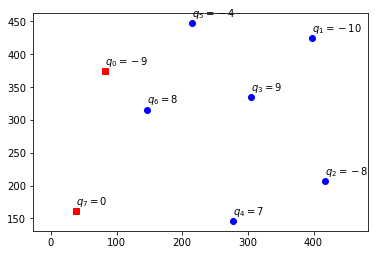

In [135]:
for point in coord[1:]:   
    plt.scatter(point[0], point[1], c='b')

for i in V:
    plt.annotate('$q_%d=%d$' % (i, q[i]), (coord[i][0], coord[i][1]+10))

plt.plot(coord[0][0], coord[0][1], c='r', marker='s') #marker=(5, 1)
plt.plot(coord[end][0], coord[end][1], c='r', marker='s') 
plt.axis('equal')

In [136]:
# Model
f4 = Model('Formulation-F4')

# Decision variables
x = f4.binary_var_dict(A_tilde, name='x')
f = f4.continuous_var_dict(A_tilde, name='f')
g = f4.continuous_var_dict(A_tilde, name='g')

In [137]:
#Function to minimize
f4.minimize(f4.sum(c[i, j]*x[i, j] for i in V for j in V))

#Constraints
f4.add_constraints(f4.sum(x[i, j] for i in V) == 1 for j in Vo) #17

f4.add_constraints(f4.sum(x[j, i] for i in V) == 1 for j in Vo) #18

f4.add_constraint(f4.sum(x[0, j] for j in V) <= m ) #19

f4.add_constraint(f4.sum(x[0, j] for j in Vo) == f4.sum(x[i, n-1] for i in Vo)) #20

for i in range(1, len(Vo) + 1):
    for S in itertools.permutations(Vo, i):
        f4.add_constraint(f4.sum(x[i, j] for j in S for i in S) <= len(S)-1) # 21
        
f4.add_constraints((f[i,j] + g[j,i]) == Q * x[i,j] for i in V for j in V)       #22
f4.add_constraints((f4.sum((f[j, i] - g[i,j]) for i in V) - f4.sum((f[i, j] - g[j,i]) for i in V)) == 2*q[j] for j in Vo) #23
f4.add_constraint(f4.sum(f[0,j] for j in Vo) >= f4.max(0, -Qtot)) #24
f4.add_constraint(f4.sum(f[j,end] for j in Vo) >= f4.max(0, Qtot)) #25

f4.add_constraint((f4.sum(g[j,0] for j in Vo) <= min(m*Q, m*Q + Qtot)))                   #26
f4.add_constraints((max(0,q[i],-q[j]) * x[i,j]) <= f[i,j] for i in V for j in V)                   #27_1
f4.add_constraints(f[i,j] <= (min(Q,Q + q[i],Q -q[j]) * x[i,j])  for i in V for j in V)                   #27_2
f4.add_constraints(((Q - min(Q, Q + q[i], Q - q[j])) * x[i,j]) <= g[i,j] for i in V for j in V)                 #28_1
f4.add_constraints(g[i,j] <= ((Q - max(0, q[i], - q[j])) * x[i,j])  for i in V for j in V)                   #28_2
solutionF4 = f4.solve(log_output=True)
f4.solve(log_output=True)


Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Row 'c7' infeasible, all entries at implied bounds.
Presolve time = 0.02 sec. (2.34 ticks)

Root node processing (before b&c):
  Real time             =    0.02 sec. (3.22 ticks)
Parallel b&c, 8 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.02 sec. (3.22 ticks)
Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Row 'c7' infeasible, all entries at implied bounds.
Presolve time = 0.00 sec. (2.34 ticks)

Root node processing (before b&c):
  Real time             =    0.00 sec. (3.22 ticks)
Parallel b&c, 8 threads:
  Real time             =    0.00 sec. 

In [16]:
print(solutionF4)


None


In [17]:
print(solutionF4.solve_details)


AttributeError: 'NoneType' object has no attribute 'solve_details'

In [18]:
active_arcs = [a for a in A_tilde if x[a].solution_value > 0.9]
plt.scatter(loc_x[1:], loc_y[1:], c='b')
for i in V:
    plt.annotate('$q_%d=%d$' % (i, q[i]), (loc_x[i]+2, loc_y[i]))
for i, j in active_arcs:
    plt.plot([loc_x[i], loc_x[j]], [loc_y[i], loc_y[j]], c='g', alpha=0.3)
plt.plot(loc_x[0], loc_y[0], c='r', marker='s')
plt.axis('equal')

DOcplexException: Model<Formulation-F4> did not solve successfully